In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm
from cartopy.feature import NaturalEarthFeature

In [5]:
plt.rcParams.update({
    'font.family':        'sans-serif',
    'font.sans-serif':    ['Arial'],
    'font.size':          22,
    'axes.titlesize':     22,
    'axes.labelsize':     15,
    'xtick.labelsize':    15,
    'ytick.labelsize':    15,
    'legend.fontsize':    17,

    'axes.linewidth':     1.5,
    'xtick.major.size':   8,
    'xtick.major.width':  1.5,
    'ytick.major.size':   8,
    'ytick.major.width':  1.5,
    'xtick.minor.size':   5,
    'xtick.minor.width':  0.75,
    'ytick.minor.size':   5,
    'ytick.minor.width':  0.75,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,

    'xtick.direction':    'in',
    'ytick.direction':    'in',

    'xtick.major.pad':    5,
    'ytick.major.pad':    5,
    'xtick.minor.pad':    5,
    'ytick.minor.pad':    5,

    'axes.labelpad':      7,
    'axes.titlepad':      7,
})


In [6]:
colors = np.array([
    [255, 255, 255],
    [181, 201, 255],
    [99, 112, 247],
    [0, 99, 255],
    [0, 150, 150],
    [0, 198, 51],
    [99, 255, 0],
    [198, 255, 51],
    [255, 255, 0],
    [255, 198, 0],
    [255, 124, 0],
    [255, 25, 0]
])

colors = colors / 255.0
cmap = ListedColormap(colors)
boundaries = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6]
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)
custom_ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6]
custom_labels = [str(x) for x in custom_ticks]


In [7]:
mod_file = "../../model_output/LUCY_US_new_BEM/history/LUCY_US_new_BEM_hist_2010.nc"
b_file = "../../model_output/LUCY_US_new_BEM/landdata/diag/patchfrac_elm_2010.nc"
fl_file = "../../model_output/LUCY_US_new_BEM/history/Flanner_US.nc"
jp_file = "../../model_output/LUCY_US_new_BEM/history/AH4GUC_US.nc"

mod_data = xr.open_dataset(mod_file)
b_data = xr.open_dataset(b_file)
fl_data = xr.open_dataset(fl_file)
jp_data = xr.open_dataset(jp_file)

bb = b_data.patchfrac_elm
bbb = bb[13,:,:]#.sum(dim='TypeIndex')

mod_ahe = (mod_data.f_fwst + mod_data.f_fhac + mod_data.f_fvehc + mod_data.f_fmeta + mod_data.f_fhah)*bbb
mod_ahe_mean = mod_ahe.mean(dim='time')

jp_ahe = jp_data.AHE.where(bbb > 0, np.nan)

jp_ahe_mean = jp_ahe.mean(dim='record')

fl_ahe = fl_data.AHF
fl_ahe = fl_ahe.assign_coords(lat=b_data.lat, lon=b_data.lon)
fl_ahe = fl_ahe.where(bbb > 0, np.nan)
fl_ahe_mean = fl_ahe.assign_coords(lat=mod_data.lat, lon=mod_data.lon)

jp_ahe = jp_data.AHE.where(bbb > 0, np.nan)

In [8]:
r_monthly = []
for i in range(12):
    mod_slice = mod_ahe[i,:,:]
    jp_slice = jp_ahe[i,:,:]
    mod_vals = mod_slice.values.flatten()
    jp_vals = jp_slice.values.flatten()
    mask = ~np.isnan(mod_vals) & ~np.isnan(jp_vals)
    if mask.sum() > 0:
        corr = np.corrcoef(mod_vals[mask], jp_vals[mask])[0,1]
    else:
        corr = np.nan
    r_monthly.append(corr)

def spatial_stats(a, b):
    a_vals = a.values.flatten()
    b_vals = b.values.flatten()
    mask = ~np.isnan(a_vals) & ~np.isnan(b_vals)
    if mask.sum() == 0:
        return np.nan, np.nan
    a_mask = a_vals[mask]
    b_mask = b_vals[mask]
    corr = np.corrcoef(a_mask, b_mask)[0,1]
    rmse = np.sqrt(np.mean((a_mask - b_mask)**2))
    return corr, rmse

corr_fl, rmse_fl = spatial_stats(mod_ahe_mean, fl_ahe_mean)
corr_jp, rmse_jp = spatial_stats(mod_ahe_mean, jp_ahe_mean)
print(f"mod_ahe_mean vs fl_ahe_mean: corr={corr_fl:.3f}, RMSE={rmse_fl:.3f}")
print(f"mod_ahe_mean vs jp_ahe_mean: corr={corr_jp:.3f}, RMSE={rmse_jp:.3f}")


mod_ahe_mean vs fl_ahe_mean: corr=0.912, RMSE=0.984
mod_ahe_mean vs jp_ahe_mean: corr=0.901, RMSE=0.595


/tmp/ipykernel_1528948/3739674355.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.1, 1, 1])


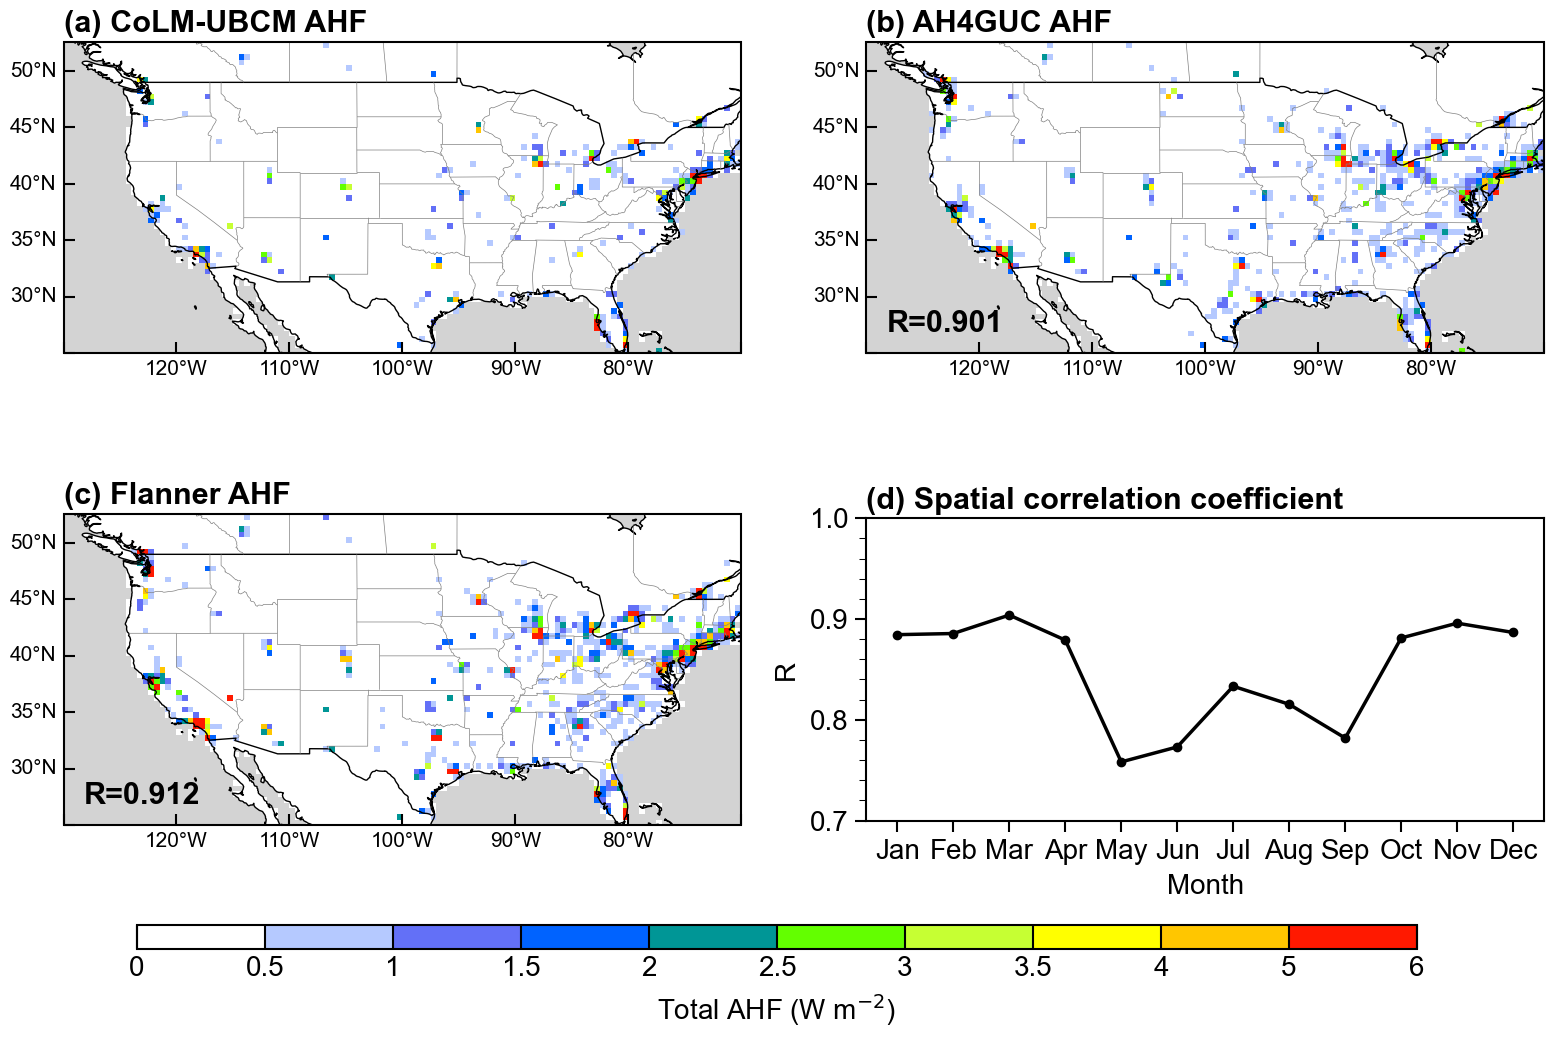

In [9]:
states = NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none'
)

lon_ticks = np.arange(-130, -60, 10)
lat_ticks = np.arange(25, 55, 5)
fig = plt.figure(figsize=(16, 12))
for idx, data, title_text, stat_text in zip(
    [1, 2, 3],
    [mod_ahe_mean, jp_ahe_mean, fl_ahe],
    ["(a) CoLM-UBCM AHF", "(b) AH4GUC AHF", "(c) Flanner AHF"],
    [" ", f"R={corr_jp:.3f}", f"R={corr_fl:.3f}"]
):
    ax = fig.add_subplot(2, 2, idx, projection=ccrs.PlateCarree())
    mesh = ax.pcolormesh(
        mod_data.lon, mod_data.lat, data,
        norm=norm, cmap=cmap
    )
    ax.set_extent([-130, -70, 25, 49])
    ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
    ax.add_feature(cfeature.LAND, facecolor='none')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(states, edgecolor='gray', linewidth=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(axis='x', which='major', labelsize=0, direction='in')
    ax.tick_params(axis='x', which='minor', labelsize=0, length = 0, direction='in')
    ax.tick_params(axis='y', which='minor', labelsize=0, length = 0, direction='in')
    ax.tick_params(axis='y', which='major', labelsize=0, direction='in')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title_text, loc='left', weight='bold')
    ax.text(0.03, 0.05, stat_text, transform=ax.transAxes,
            ha='left', va='bottom', weight='bold')

ax4 = fig.add_subplot(2, 2, 4)
months = np.arange(1, 13)
my_data = r_monthly#[0.873, 0.873, 0.883, 0.812, 0.634, 0.686, 0.784, 0.752, 0.673, 0.814, 0.874, 0.875]
ax4.plot(months, my_data, '-o', color='k', linewidth=2.5)
ax4.set_xlabel("Month", fontsize=20)
ax4.set_ylabel("R", fontsize=20)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax4.set_xticks(months)
ax4.set_xticklabels(month_labels, fontsize=20)
ax4.tick_params(axis='x', length=0, which='minor')
ax4.tick_params(axis='y', labelsize=20, direction='out', which='both')
ax4.tick_params(axis='x', direction='out')
ax4.set_title("(d) Spatial correlation coefficient", loc='left', weight='bold')
ax4.set_ylim(0.7, 1)
ax4.set_aspect(18)
# ax4.grid(True)

cbar_ax = fig.add_axes([0.1, 0.12, 0.8, 0.02])
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax, orientation='horizontal', ticks=custom_ticks
)
cbar.set_label('Total AHF (W m$^{-2}$)', fontsize=20)
cbar.ax.set_xticklabels([str(l) for l in custom_ticks], fontsize=20)
cbar.ax.tick_params(axis='x', which='major', labelsize=20, length=17, width=1.5, direction='in')
cbar.outline.set_linewidth(1.5)

fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('Figure18.jpg', dpi=300)
plt.show()